# 3DFlex Project

## Tetrahedral Mesh in a Cube $[0,1]^3$

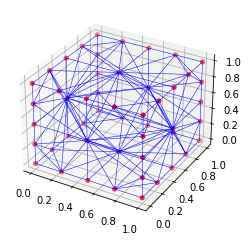

In [40]:
from meshpy.tet import MeshInfo, build
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mesh_info = MeshInfo()

#create a mesh on a cube [0,1]^3
mesh_info.set_points([
    (0,0,0), (1,0,0), (1,1,0), (0,1,0),
    (0,0,1), (1,0,1), (1,1,1), (0,1,1),
    ])
mesh_info.set_facets([
    [0,1,2,3],
    [4,5,6,7],
    [0,4,5,1],
    [1,5,6,2],
    [2,6,7,3],
    [3,7,4,0],
    ])
    
# max-volume sets the maximum volume of each small tetrahedron element.
mesh = build(mesh_info, max_volume = 0.1)

# mesh data can be output as a paraview readable file. Using code: 
# mesh.write_vtk("test.vtk")

E, P = np.array(mesh.elements), np.array(mesh.points)

# Option to print out the mesh points and elements
# print ("Mesh Points:")
# for i, p in enumerate(P):
#    print (i, p)
# print ("Point numbers in tetrahedra:")
# for i, t in enumerate(E):
#     print (i, t)

# Filter out the unique pairs of edges before drawing 
pairs1 = np.r_[E[:,[0,1]],E[:,[1,2]],E[:,[2,3]],E[:,[3,0]],E[:,[0,2]],E[:,[1,3]]]
for i, pair in enumerate(pairs1):
    if pair[0] > pair [1]:
        pairs1[i,0],pairs1[i,1] = pairs1[i,1], pairs1[i,0]
pairs2 = np.unique(pairs1, axis = 0)

# Form the line segments
segments = P[pairs2[:,:]]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# draw the vertices of each tetrahedral elements
ax.scatter(P[:,0],P[:,1],P[:,2], color = 'r',linewidths = 0.5)
# draw the edges of each tetrahedral elements
ax.add_collection3d(Line3DCollection(segments, colors='b', linewidths=0.5, linestyles='-'))
    
plt.show()

## 3D Density Map: Torus as the Domain. 
The domain of the density map is a torus,
$$ \{(x,y,z)\in \mathbb R^3:(R-\sqrt{(x-x_0)^2+(y-y_0)^2})^2+(z-z_0)^2 = r^2\} $$

where $(x_0,y_0,z_0)$ is the center of the torus.\
$r$ is the radius of the tube.\
And $R$ is the radius of the disc.

The density maps $V(x,y,z)$
$$V:\mathbb R^3 \to \mathbb R$$
$$(x,y,z)\mapsto \frac 1d \sqrt{(x-x_0)^2+(y-y_0)^2+(z-z_0)^2}$$
where $d$ is a scaling factor such that the output distance is alwasy in $[0,1]$.

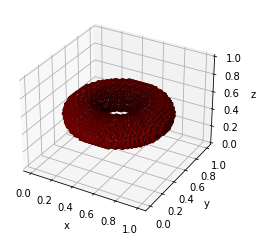

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x
# set 'N' so that the number of voxels in a cube [0,1]^3 will be N^3.
N = 40

# prepare the coordinates for each voxel
X, Y, Z = np.indices((N, N, N)) / (N-1)
x = midpoints(X)
y = midpoints(Y)
z = midpoints(Z)

# define the torus domain centred at [0.5, 0.5, 0.5] with R = 0.3 and r = 0.1
torus = (0.3 - ((x -0.5) ** 2 + (y - 0.5) ** 2) ** (0.5)) ** 2 + (z - 0.5)**2 < 0.15**2

# denfine the density function 3D
f = (2/3**(0.5))*((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2)**(0.5)
V = np.multiply(f, torus.astype(int))

# combine the color components
colors = np.zeros(torus.shape + (3,))
colors[..., 0] = V
# colors[..., 1] = V
# colors[..., 2] = V

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(X, Y, Z, torus,
          facecolors=colors,
          #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          edgecolors = 'k',
          linewidth=0.5/N)
ax.set(xlabel='x', ylabel='y', zlabel='z')

plt.show()

## Define the Map from Canonical Coordinates to Deformed Coordinate
$$u:\mathbb R^3 \to \mathbb R^3$$
$$ \mathbf{x}\mapsto u(\mathbf{x})$$
$$u(\mathbf{x}) = \frac {5}{N\sqrt {(x-1.5)^2+(y-0.5)^2+(z-0.5)^2}}(1.5-x,0.5-y,0.5-z) $$

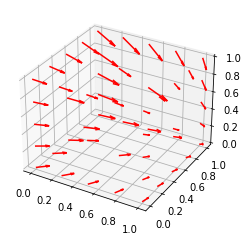

In [55]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# only draw the flow vector fields on the vertices of tetrahedron
vectors = np.zeros(P.shape)

vectors[:,0] = (5.0/N)*(1.5 - P[:,0])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)
vectors[:,1] = (5.0/N)*(0.5 - P[:,1])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)
vectors[:,2] = (5.0/N)*(0.5 - P[:,2])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)
    
ax.quiver(P[:,0],P[:,1],P[:,2], vectors[:,0], vectors[:,1], vectors[:,2], length=1, color = 'red')

plt.show()

## Associate Each Voxel with the Correct Tetrahedron Element

In [56]:
# import time if time complexity is run. 
# alternatively, import cupy as np if len(points)>1e7 and GPU
import numpy as np 

def Tetrahedron(vertices):
    """
    Given a list of the xyz coordinates of the vertices of a tetrahedron, 
    return tetrahedron coordinate system
    """
    origin, *rest = vertices
    mat = (np.array(rest) - origin).T
    tetra = np.linalg.inv(mat)
    return tetra, origin

def pointInside(point, tetra, origin):
    """
    Takes a single point or array of points, as well as tetra and origin objects returned by 
    the Tetrahedron function.
    Returns a boolean or boolean array indicating whether the point is inside the tetrahedron.
    """
    newp = np.matmul(tetra, (point-origin).T).T
    return np.all(newp>=0, axis=-1) & np.all(newp <=1, axis=-1) & (np.sum(newp, axis=-1) <=1)


voxels = np.array([np.reshape(x,(x.size,)), np.reshape(y,(y.size,)), np.reshape(z,(z.size,))]).T
indices = np.zeros((voxels.shape[0],1))

# this for loop can be improved for time consumption by swaping enumerate(voxels) and enumerate(E). 

for i, points in enumerate(voxels):
    for j, vertices in enumerate(E):
        tetra, origin = Tetrahedron(P[vertices])
        inTet = pointInside(points, tetra, origin)
        if inTet == True:
            indices[i] = j        

#print(voxels)       


# test for time complexity
# npt=10000000
# points = np.random.rand(npt,3)
# # Coordinates of vertices A, B, C and D
# A=np.array([0.1, 0.1, 0.1])
# B=np.array([0.9, 0.2, 0.1])
# C=np.array([0.1, 0.9, 0.2])
# D=np.array([0.3, 0.3, 0.9])

# start_time = time.time()
# vertices = [A, B, C, D]
# tetra, origin = Tetrahedron(vertices)
# inTet = pointInside(points, tetra, origin)
# print("--- %s seconds ---" % (time.time() - start_time))


## Interpolating Flow Fields at each Voxels

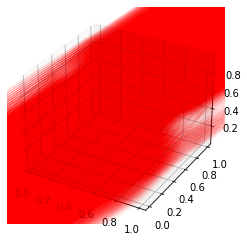

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# assemble the shape function matrix
def shape_function(P, E, vectors):
    M = np.zeros((E.shape[0], 3, 4))
    
    for i, elements in enumerate(E):
        M[i] = np.matmul(vectors[elements].T, np.linalg.inv(np.c_[np.ones((4,1)),P[elements]]))
    return M

# interpolating the flow vector at each voxel point.
def interpolation(voxels, indices, M):
    voxels_v = np.zeros(voxels.shape)
    coordinates = np.c_[np.ones((voxels.shape[0],1)),voxels]
    for i, points in enumerate(coordinates):
        voxels_v[i] = np.matmul(M[int(indices[i])], points.T)
    return voxels_v

M = shape_function(P, E, indices)
voxels_v = interpolation(voxels, indices, M)

#print(voxels_v)  

# draw the flow vector fields at each voxel
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.quiver(voxels[:,0], voxels[:,1], voxels[:,2], voxels_v[:,0], voxels_v[:,1], voxels_v[:,2], linewidth = 1/N, length=1/N, color = 'red')
plt.show()


## Define the Kernel Function
$$k:\mathbb R^3 \to \mathbb R$$
$$ \mathbf{x} \mapsto \left\{
\begin{array}{ll}
      1 & \max (|x|, |y|, |z|) < \frac{1}{2N} \\
      0.1 & \frac{1}{2N}\le\max (|x|, |y|, |z|)<\frac{2}{3N} \\
      0 & \text{otherwise}
\end{array} 
\right.$$ 

where $\frac 1N$ is the side length of each voxel

In [58]:
import numpy as np

def kernel(points, N):
    d = max(np.absolute(points)) 
    d_max = 1.0/(2.0*N)
    if d < d_max:
        return 1
    elif d >= d_max and d < 1.5*d_max:
        return 0.1
    else:
        return 0

## Calculate the Deformed Density Map

$$W:\mathbb R^3\to \mathbb R^3$$
$$\mathbf{x}\mapsto \sum_\mathbf{y} k(\mathbf{x}-u(\mathbf{y}))$$

In [61]:
import numpy as np
import matplotlib.pyplot as plt

Nvoxels = np.add(voxels, voxels_v)
V1 = np.reshape(V,(1,-1)).T
W = np.zeros(V.shape)


# This loop definitely can be improved for time complexity!!!
for i, point in enumerate(voxels):
# Instead of searching for the entire list of Nvoxels, one can limit the search list to the surrounding points of i
    for j, Npoint in enumerate(Nvoxels):
        W[i] += kernel(np.subtract(point,Npoint),N)*V1[j]
print(W)


colors = np.zeros(torus.shape + (3,))
colors[..., 0] = W
# colors[..., 1] = V
# colors[..., 2] = V

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(X, Y, Z, W.reshape((N-1,N-1,N-1)) > 0,
          facecolors=colors,
          #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          edgecolors = 'k',
          linewidth=0.5/N)
ax.set(xlabel='x', ylabel='y', zlabel='z')

plt.show()




 

IndexError: index 39 is out of bounds for axis 0 with size 39